# Network Architecture
## Main purpose of this notebook is to compare the results with the network architecture

In [2]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime
import os.path

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [33]:
# Import preprocessed data
file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/'
file_version = 'ws100num3derFalse'
sensors = ['back_angle', 'left_angle', 'right_angle']
file_name = f'{file_version}-augment.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (44469, 100, 3)


## Single - 128

In [6]:
time_code = '164500_0416'
model_file = f'{time_code}-model.h5'
model_file

'164500_0416-model.h5'

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128)               67584     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 100, 128)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 128)          131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 100, 3)            387       
Total params: 199,555
Trainable params: 199,555
Non-trainable params: 0
________________________________________________

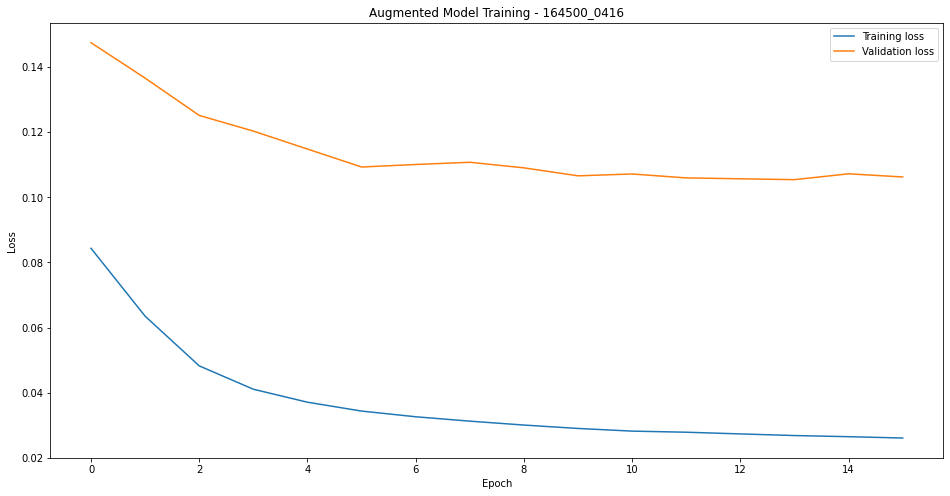

In [11]:
# Fit the model
if os.path.isfile(model_file):
    model = load_model(model_file)
    print(f"Loaded {model_file}")

    model.summary()
    for layer in model.layers:
        print(layer.input_shape)
else:
    # Define AutoEncoder architecture
    model = Sequential()
    # Encoder
    model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
    model.add(Dropout(rate=0.2))
    # model.add(LSTM(64, return_sequences=False))
    # Bridge
    model.add(RepeatVector(trainX.shape[1]))
    #Decoder
    # model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(TimeDistributed(Dense(trainX.shape[2])))
    model.compile(optimizer='adam', loss='mae')


    model.summary()
    for layer in model.layers:
        print(layer.input_shape)


    callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
    history = model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])

    # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Augmented Model Training - {time_code}")
    plt.legend()
    diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
    diag_file_name = f'training-{time_code}.png'
    plt.savefig(f'{diag_file_path}{diag_file_name}')

    
    model.save(model_file)
    print(f"Saved as {model_file}")


In [24]:
# Load just the patient data
file_patient = f'{file_version}-patient.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of control training samples: {patientX.shape}')

Number of control training samples: (40601, 100, 3)


In [25]:
patientPredict = model.predict(patientX)

In [ ]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

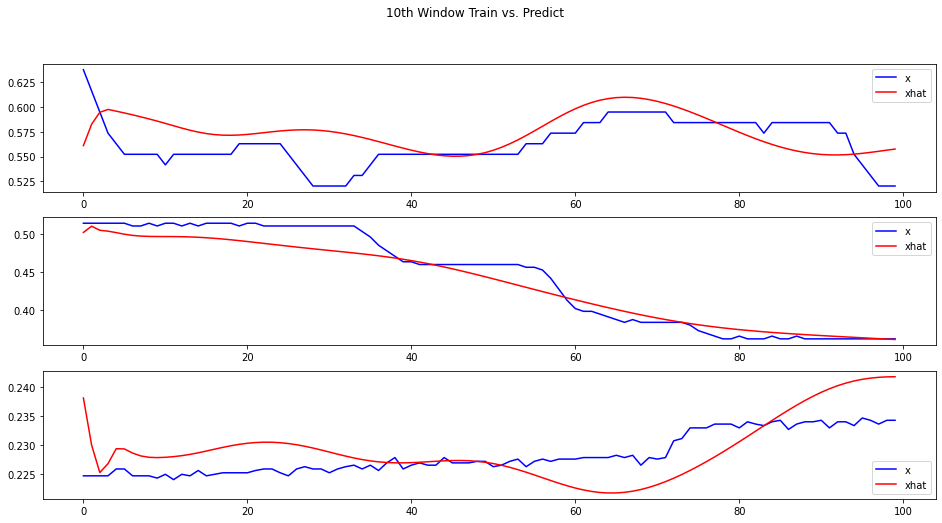

In [26]:
train_plot = patientX[example]
predict_plot = patientPredict[example]
x_plot = list(range(seq_size))
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 8))

fig.suptitle(f"{example}th Window Train vs. Predict")

for sensor in range(no_feats):
    sns.lineplot(x=x_plot, y=train_plot[:,sensor], color='b', ax=axes[sensor], label='x')
    sns.lineplot(x=x_plot, y=predict_plot[:,sensor], color='r', ax=axes[sensor], label='xhat')

plt.legend()


In [27]:
error = np.abs(patientPredict - patientX)
trainMAE = np.mean(error, axis=1) # changed from max
trainMAE.shape

(40601, 3)

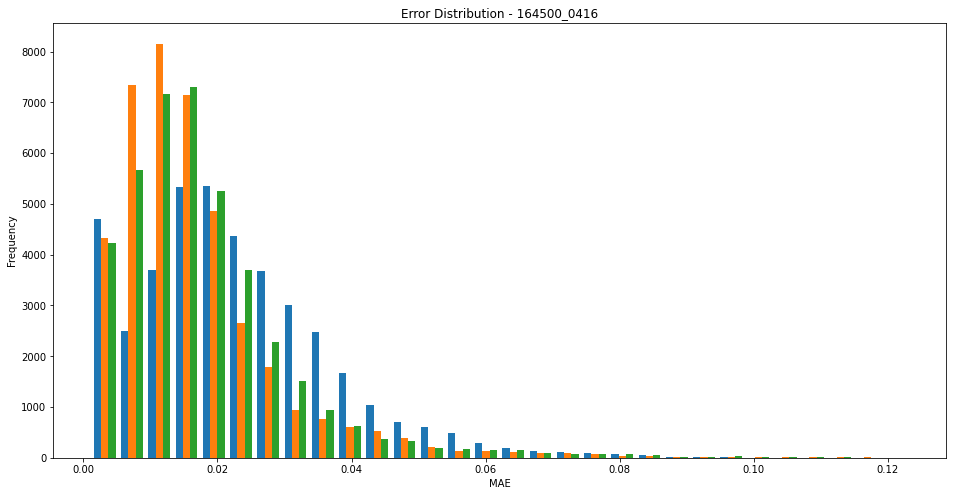

In [28]:
plt.figure(figsize=(16, 8))
_ = plt.hist(trainMAE, bins=30)
plt.xlabel("MAE")
plt.ylabel("Frequency")
plt.title(f"Error Distribution - {time_code}")
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-hist-{time_code}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')

In [37]:
# Retrieve data and place with pd dataframe
patient_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['datetime'])
df = dataframe.loc[:,sensors]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])

# Split test and train data
train, test = df.loc[df['Date'] <= '2011-12-01 11:38:00'], df.loc[df['Date'] > '2011-12-01 11:38:00']
train

back_angle  left_angle  right_angle                    Date
0        0.424307    0.600144     0.237863 2011-12-01 11:04:05.000
1        0.456290    0.596542     0.223615 2011-12-01 11:04:05.050
2        0.488273    0.592939     0.223615 2011-12-01 11:04:05.100
3        0.530917    0.585735     0.224274 2011-12-01 11:04:05.150
4        0.573561    0.571326     0.223615 2011-12-01 11:04:05.200
...           ...         ...          ...                     ...
40696    0.573561    0.675793     0.164947 2011-12-01 11:37:59.800
40697    0.573561    0.639769     0.165277 2011-12-01 11:37:59.850
40698    0.573561    0.618156     0.164947 2011-12-01 11:37:59.900
40699    0.584222    0.607349     0.164301 2011-12-01 11:37:59.950
40700    0.584222    0.578530     0.164631 2011-12-01 11:38:00.000

[40701 rows x 4 columns]

In [41]:
thresh_pct = 0.8
max_trainMAE = [thresh_pct * np.amax(trainMAE)] * len(train[seq_size:])  #or Define 90% value of max as threshold.
max_trainMAE = np.array(max_trainMAE).flatten()
max_trainMAE.shapethr

(40601,)

In [42]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(train[seq_size:])
anomaly_df['trainMAE'] = np.max(trainMAE, axis=1)
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['trainMAE'] > anomaly_df['max_trainMAE']

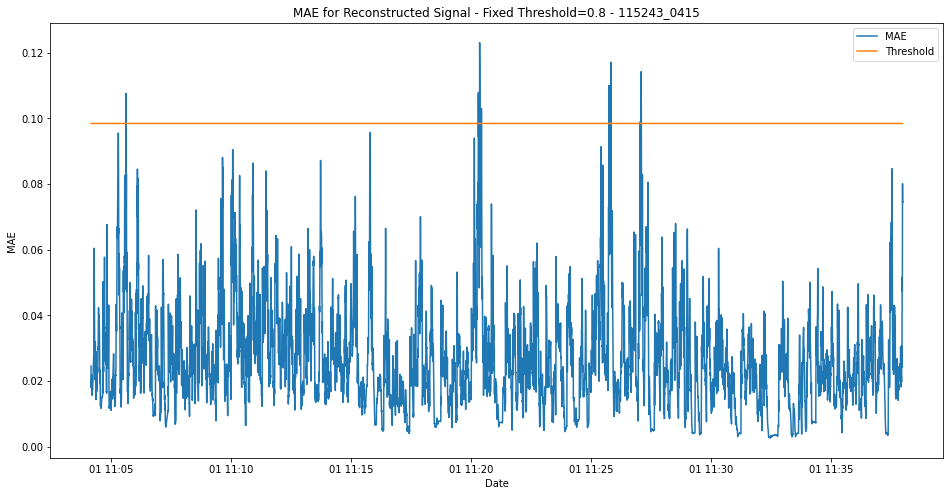

In [43]:
#Plot testMAE vs max_trainMAE
plt.figure(figsize=(16, 8))
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['trainMAE'], label='MAE')
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'], label='Threshold')
plt.xlabel("Date")
plt.ylabel("MAE")
plt.title(f"MAE for Reconstructed Signal - Fixed Threshold={thresh_pct} - 115243_0415")
plt.legend()
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-thresh-{thresh_pct}-{time_code}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [44]:
print(anomalies)

       back_angle  left_angle  right_angle                    Date  trainMAE  \
1843     0.434968    0.520893     0.184037 2011-12-01 11:05:37.150  0.098622   
1844     0.456290    0.517291     0.184037 2011-12-01 11:05:37.200  0.100163   
1845     0.466951    0.517291     0.183773 2011-12-01 11:05:37.250  0.101955   
1846     0.498934    0.517291     0.184697 2011-12-01 11:05:37.300  0.103112   
1847     0.520256    0.520893     0.184433 2011-12-01 11:05:37.350  0.104207   
...           ...         ...          ...                     ...       ...   
27620    0.594883    0.391210     0.220053 2011-12-01 11:27:06.000  0.113447   
27621    0.594883    0.380403     0.219129 2011-12-01 11:27:06.050  0.111820   
27622    0.594883    0.384006     0.220976 2011-12-01 11:27:06.100  0.109031   
27623    0.594883    0.380403     0.219789 2011-12-01 11:27:06.150  0.105404   
27624    0.584222    0.380403     0.220976 2011-12-01 11:27:06.200  0.100570   

       max_trainMAE  anomaly  
1843    

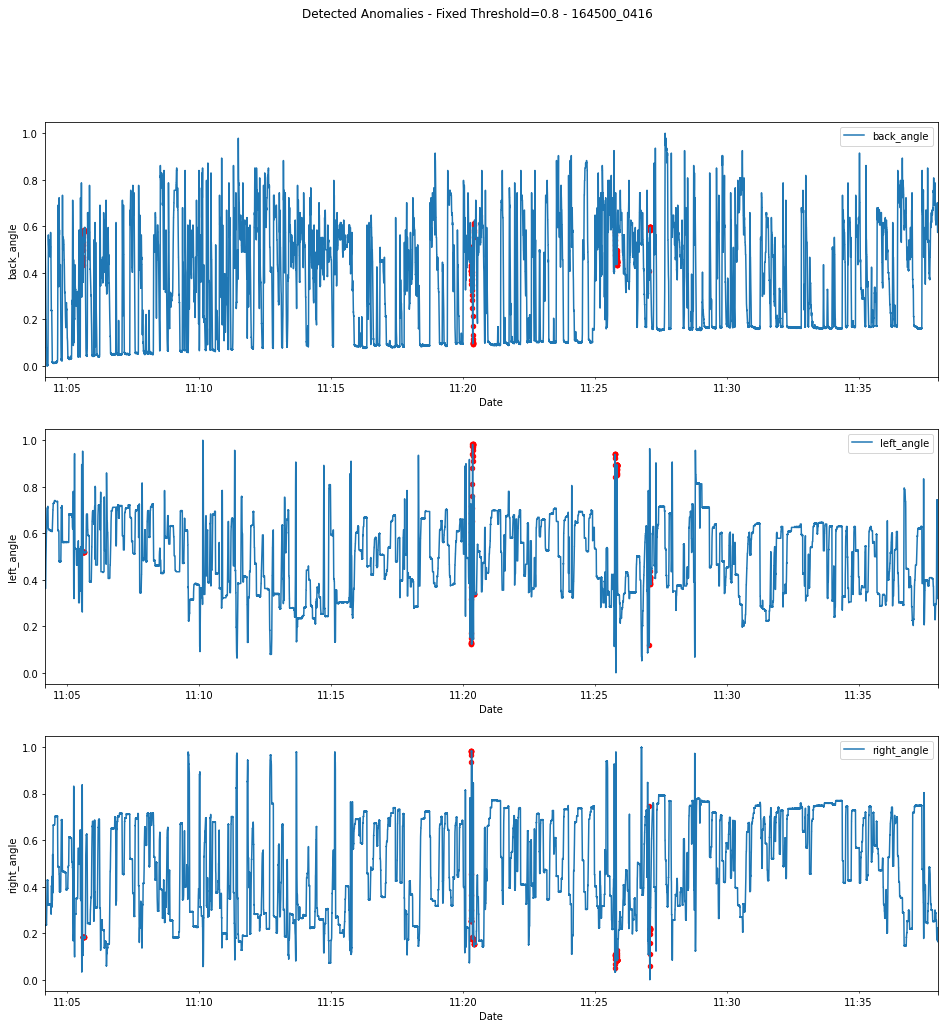

In [45]:
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 16))
for x in range(no_feats):
    anomaly_df.plot(kind='line', x='Date', y=sensors[x], ax=axes[x])
    anomalies.plot(kind='scatter', x='Date', y=sensors[x], color='r', ax=axes[x])

fig.suptitle(f"Detected Anomalies - Fixed Threshold={thresh_pct} - {time_code}")
plt.legend()
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-thresh-{thresh_pct}-{time_code}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')

## Dual - 128 & 64

In [46]:
el_time_code = '111500_0417'
el_model_file = f'{el_time_code}-model.h5'
el_model_file

'111500_0417-model.h5'

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100, 128)          67584     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 100, 64)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 64)           33024     
_________________________________________________________________
lstm_17 (LSTM)               (None, 100, 128)          98816     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 128)         

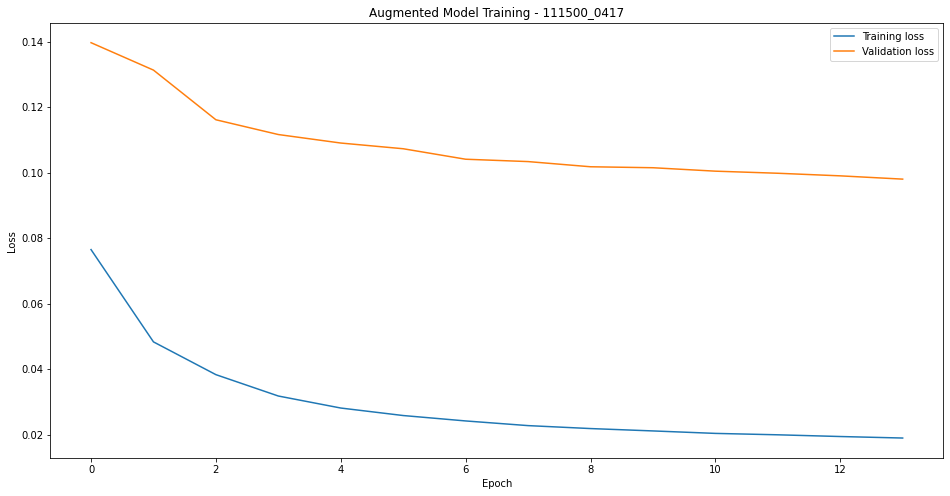

In [47]:
# Fit the model
if os.path.isfile(el_model_file):
    el_model = load_model(el_model_file)
    print(f"Loaded {el_model_file}")

    el_model.summary()
    for layer in el_model.layers:
        print(layer.input_shape)
else:
    # Define AutoEncoder architecture
    el_model = Sequential()
    # Encoder
    el_model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    el_model.add(Dropout(rate=0.2))
    el_model.add(LSTM(64, return_sequences=False))
    # Bridge
    el_model.add(RepeatVector(trainX.shape[1]))
    #Decoder
    el_model.add(LSTM(64, return_sequences=True))
    el_model.add(LSTM(128, return_sequences=True))
    el_model.add(Dropout(rate=0.2))
    el_model.add(TimeDistributed(Dense(trainX.shape[2])))
    el_model.compile(optimizer='adam', loss='mae')


    el_model.summary()
    for layer in model.layers:
        print(layer.input_shape)


    callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
    el_history = el_model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])

    # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(el_history.history['loss'], label='Training loss')
    plt.plot(el_history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Augmented Model Training - {el_time_code}")
    plt.legend()
    diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
    diag_file_name = f'training-{el_time_code}.png'
    plt.savefig(f'{diag_file_path}{diag_file_name}')

    
    el_model.save(el_model_file)
    print(f"Saved as {el_model_file}")

In [48]:
el_patientPredict = el_model.predict(patientX)

In [49]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

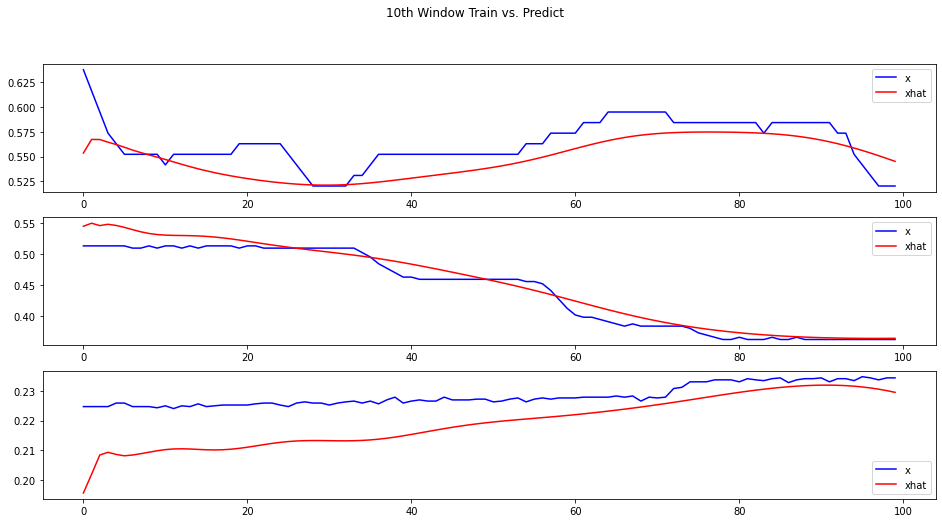

In [50]:
train_plot = patientX[example]
predict_plot = el_patientPredict[example]
x_plot = list(range(seq_size))
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 8))

fig.suptitle(f"{example}th Window Train vs. Predict")

for sensor in range(no_feats):
    sns.lineplot(x=x_plot, y=train_plot[:,sensor], color='b', ax=axes[sensor], label='x')
    sns.lineplot(x=x_plot, y=predict_plot[:,sensor], color='r', ax=axes[sensor], label='xhat')

plt.legend()

In [51]:
el_error = np.abs(el_patientPredict - patientX)
el_trainMAE = np.mean(el_error, axis=1) # changed from max
el_trainMAE.shape

(40601, 3)

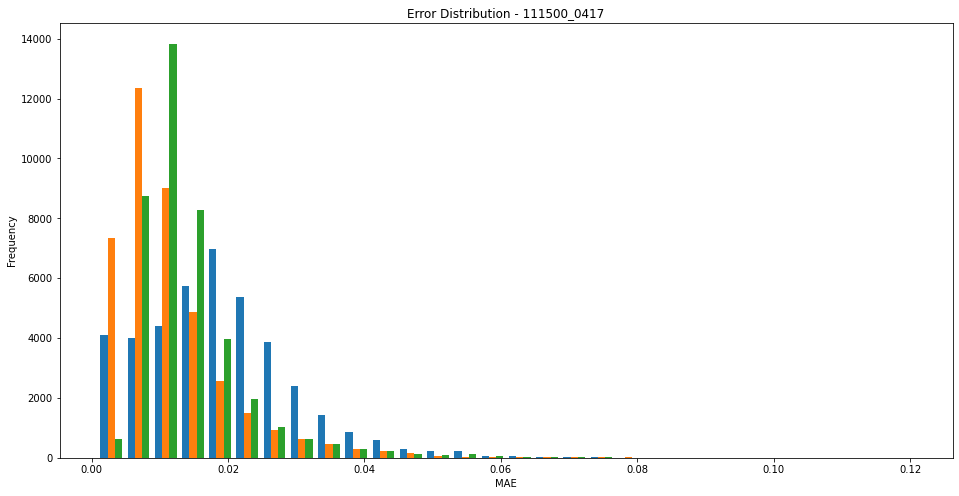

In [52]:
plt.figure(figsize=(16, 8))
_ = plt.hist(el_trainMAE, bins=30)
plt.xlabel("MAE")
plt.ylabel("Frequency")
plt.title(f"Error Distribution - {el_time_code}")
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-hist-{el_time_code}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')


In [53]:
el_thresh_pct = 0.8
el_max_trainMAE = [el_thresh_pct * np.amax(el_trainMAE)] * len(train[seq_size:])  #or Define 90% value of max as threshold.
el_max_trainMAE = np.array(el_max_trainMAE).flatten()
el_max_trainMAE.shape

(40601,)

In [54]:
#Capture all details in a DataFrame for easy plotting
el_anomaly_df = pd.DataFrame(train[seq_size:])
el_anomaly_df['trainMAE'] = np.max(el_trainMAE, axis=1)
el_anomaly_df['max_trainMAE'] = el_max_trainMAE
el_anomaly_df['anomaly'] = el_anomaly_df['trainMAE'] > el_anomaly_df['max_trainMAE']

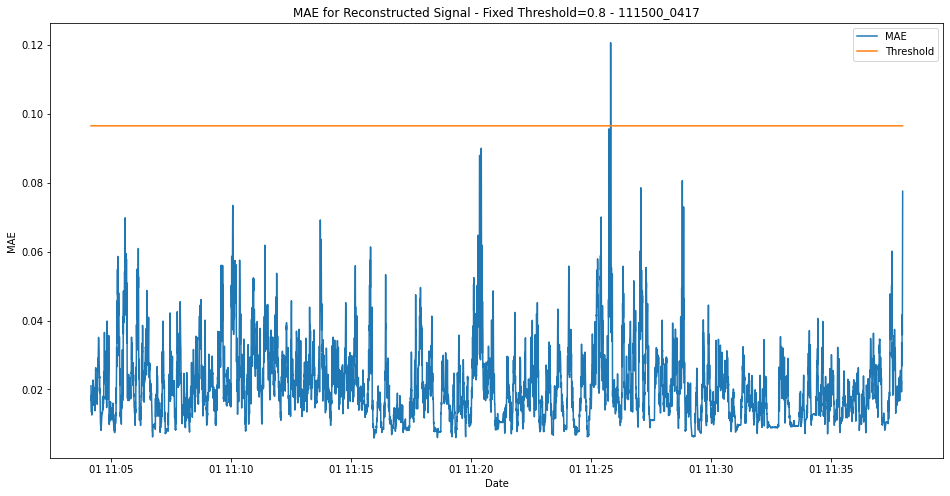

In [58]:
#Plot testMAE vs max_trainMAE
plt.figure(figsize=(16, 8))
sns.lineplot(x=el_anomaly_df['Date'], y=el_anomaly_df['trainMAE'], label='MAE')
sns.lineplot(x=el_anomaly_df['Date'], y=el_anomaly_df['max_trainMAE'], label='Threshold')
plt.xlabel("Date")
plt.ylabel("MAE")
plt.title(f"MAE for Reconstructed Signal - Fixed Threshold={el_thresh_pct} - {el_time_code}")
plt.legend()
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-thresh-{el_thresh_pct}-{el_time_code}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')
el_anomalies = el_anomaly_df.loc[el_anomaly_df['anomaly'] == True]

In [56]:
print(el_anomalies)

       back_angle  left_angle  right_angle                    Date  trainMAE  \
26086    0.562900    0.664986     0.168843 2011-12-01 11:25:49.300  0.099544   
26087    0.552239    0.708213     0.162678 2011-12-01 11:25:49.350  0.106147   
26088    0.541578    0.744236     0.151319 2011-12-01 11:25:49.400  0.111751   
26089    0.530917    0.794669     0.143536 2011-12-01 11:25:49.450  0.116084   
26090    0.520256    0.845101     0.137335 2011-12-01 11:25:49.500  0.118929   
26091    0.498934    0.877522     0.126649 2011-12-01 11:25:49.550  0.120384   
26092    0.488273    0.888329     0.115040 2011-12-01 11:25:49.600  0.120658   
26093    0.477612    0.891931     0.106332 2011-12-01 11:25:49.650  0.119380   
26094    0.466951    0.891931     0.097230 2011-12-01 11:25:49.700  0.116621   
26095    0.456290    0.891931     0.088391 2011-12-01 11:25:49.750  0.111791   
26096    0.445629    0.888329     0.083641 2011-12-01 11:25:49.800  0.106124   
26097    0.445629    0.888329     0.0832

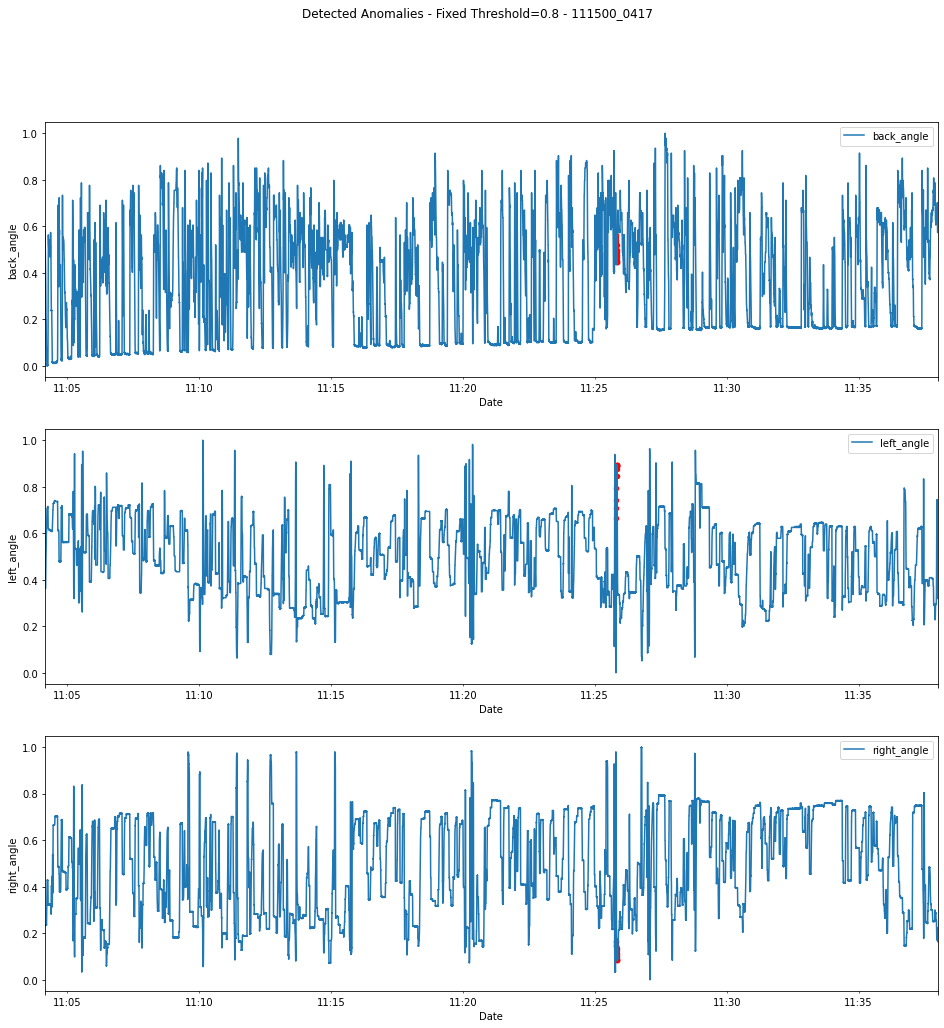

In [57]:
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 16))
for x in range(no_feats):
    el_anomaly_df.plot(kind='line', x='Date', y=sensors[x], ax=axes[x])
    el_anomalies.plot(kind='scatter', x='Date', y=sensors[x], color='r', ax=axes[x])

fig.suptitle(f"Detected Anomalies - Fixed Threshold={el_thresh_pct} - {el_time_code}")
plt.legend()
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-thresh-{el_thresh_pct}-{el_time_code}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')

## Single - No. signals x Window Size x Compression (0.6)

In [61]:
new_time_code = '220000_0418'
new_model_file = f'{new_time_code}-model.h5'
new_model_file

'220000_0418-model.h5'

In [65]:
compress = 0.6
units = int(trainX.shape[1] * trainX.shape[2] * compress)
units

180

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 180)               132480    
_________________________________________________________________
dropout_12 (Dropout)         (None, 180)               0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 100, 180)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100, 180)          259920    
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 180)          0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 100, 3)            543       
Total params: 392,943
Trainable params: 392,943
Non-trainable params: 0
________________________________________________

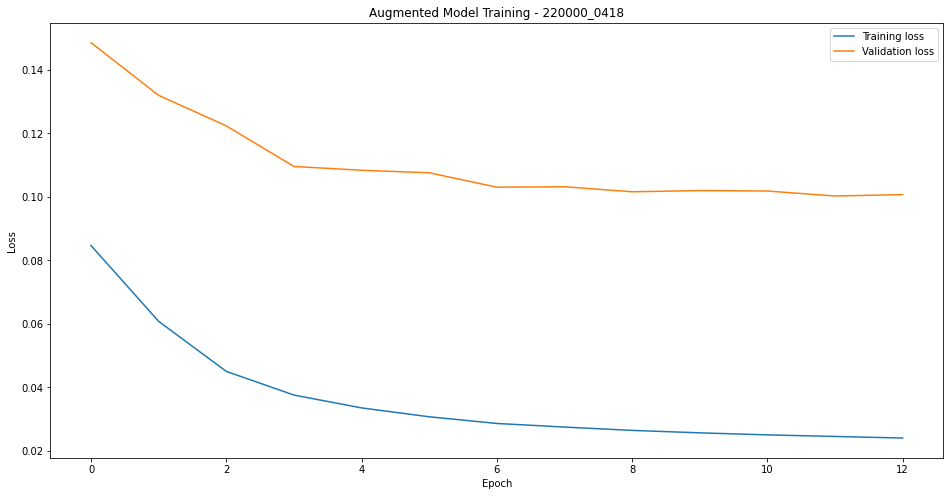

In [66]:
# Fit the model
if os.path.isfile(new_model_file):
    new_model = load_model(new_model_file)
    print(f"Loaded {new_model_file}")

    new_model.summary()
    for layer in new_model.layers:
        print(layer.input_shape)
else:
    # Define AutoEncoder architecture
    new_model = Sequential()
    # Encoder
    new_model.add(LSTM(units, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
    new_model.add(Dropout(rate=0.2))
    # new_model.add(LSTM(64, return_sequences=False))
    # Bridge
    new_model.add(RepeatVector(trainX.shape[1]))
    #Decoder
    # new_model.add(LSTM(64, return_sequences=True))
    new_model.add(LSTM(units, return_sequences=True))
    new_model.add(Dropout(rate=0.2))
    new_model.add(TimeDistributed(Dense(trainX.shape[2])))
    new_model.compile(optimizer='adam', loss='mae')


    new_model.summary()
    for layer in new_model.layers:
        print(layer.input_shape)


    callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
    new_history = new_model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])

    # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(new_history.history['loss'], label='Training loss')
    plt.plot(new_history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Augmented Model Training - {new_time_code}")
    plt.legend()
    diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
    diag_file_name = f'training-{new_time_code}.png'
    plt.savefig(f'{diag_file_path}{diag_file_name}')

    
    new_model.save(new_model_file)
    print(f"Saved as {new_model_file}")

In [121]:
# from utils import *
DIAGRAM_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'

In [70]:
new_patientPredict = new_model.predict(patientX)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

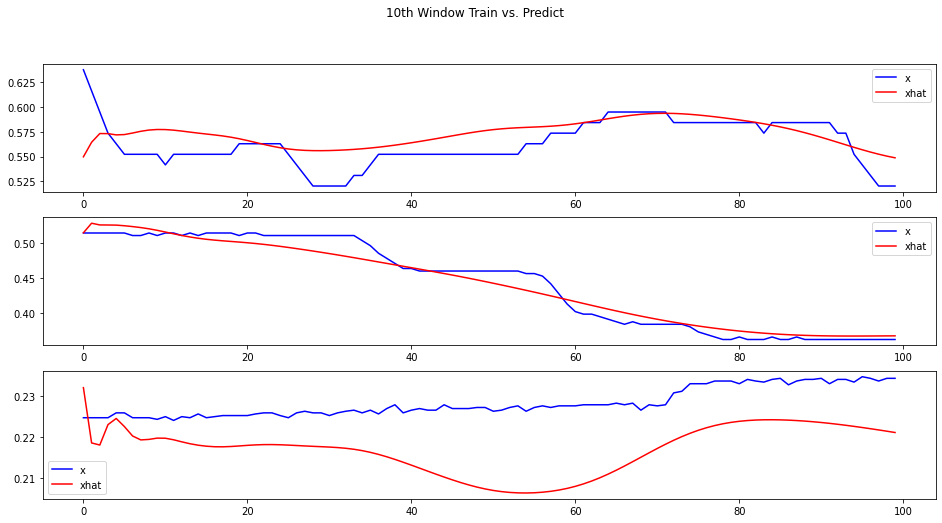

In [71]:
example_plot(10, no_feats, 100, patientX, new_patientPredict)

In [87]:
MAE = error_computation(patientX, new_patientPredict)
MAE.shape

(40601, 3)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

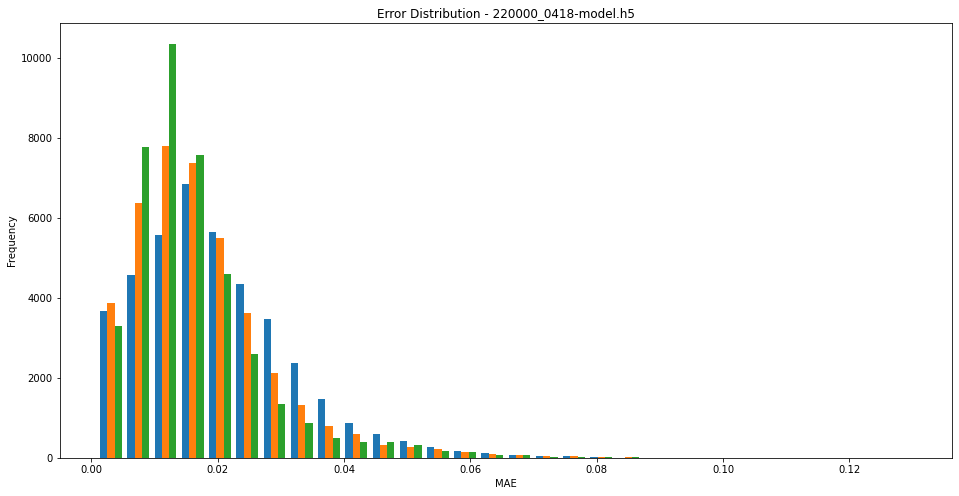

In [89]:
error_hist_and_save(MAE, new_model_file, DIAGRAM_FILE_PATH)

In [116]:
pct = 0.8
thresh = fixed_thresh(pct, MAE, len(train[seq_size:]))
thresh.shape

(40601,)

In [123]:
from utils import *

In [125]:
anomaly_what = anomaly_df(train, 100, MAE, thresh)
anomaly_what.head()

back_angle  left_angle  right_angle                    Date     error  \
100    0.584222    0.362392     0.234301 2011-12-01 11:04:10.000  0.022593   
101    0.584222    0.362392     0.232982 2011-12-01 11:04:10.050  0.021302   
102    0.573561    0.362392     0.234037 2011-12-01 11:04:10.100  0.019580   
103    0.573561    0.362392     0.234037 2011-12-01 11:04:10.150  0.017722   
104    0.552239    0.362392     0.233377 2011-12-01 11:04:10.200  0.016073   

      thresh  anomaly  
100  0.10426    False  
101  0.10426    False  
102  0.10426    False  
103  0.10426    False  
104  0.10426    False

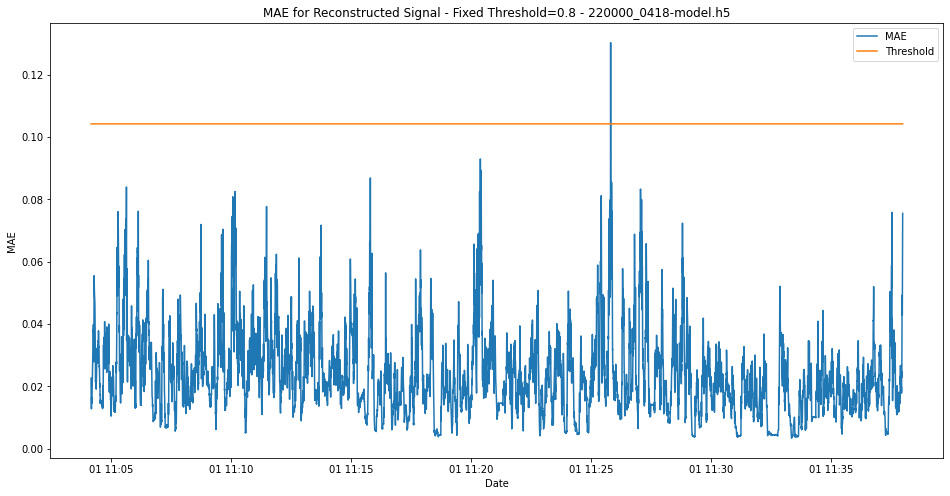

In [134]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_what, pct, new_model_file, DIAGRAM_FILE_PATH)

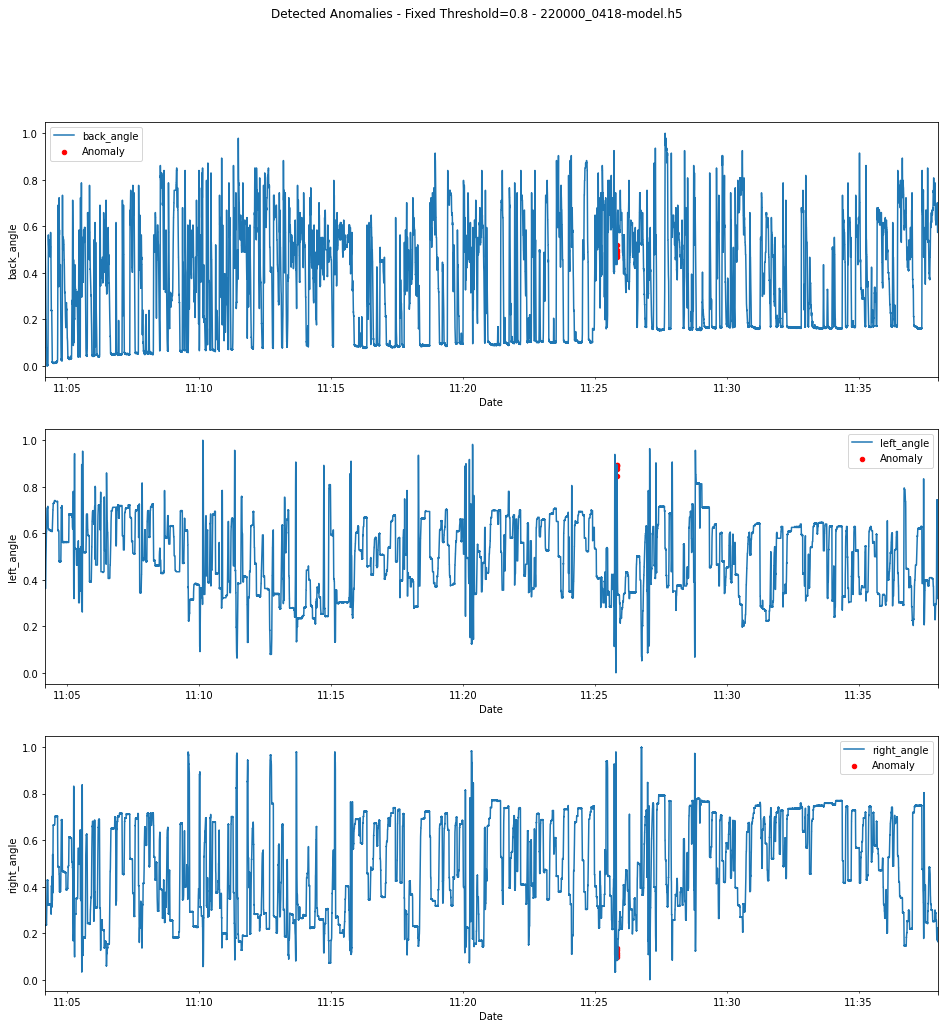

In [135]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_what, anomalies, pct, new_model_file, DIAGRAM_FILE_PATH)

## Dual - No. Signal x Window Size x Compress (0.4) & 0.5 x 1st layer

In [72]:
time_code = '093000_0419'
model_file = f'{time_code}-model.h5'
model_file

'093000_0419-model.h5'

In [77]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 100, 120)          59520     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 120)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 60)                43440     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 100, 60)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 100, 60)           29040     
_________________________________________________________________
lstm_29 (LSTM)               (None, 100, 120)          86880     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100, 120)         

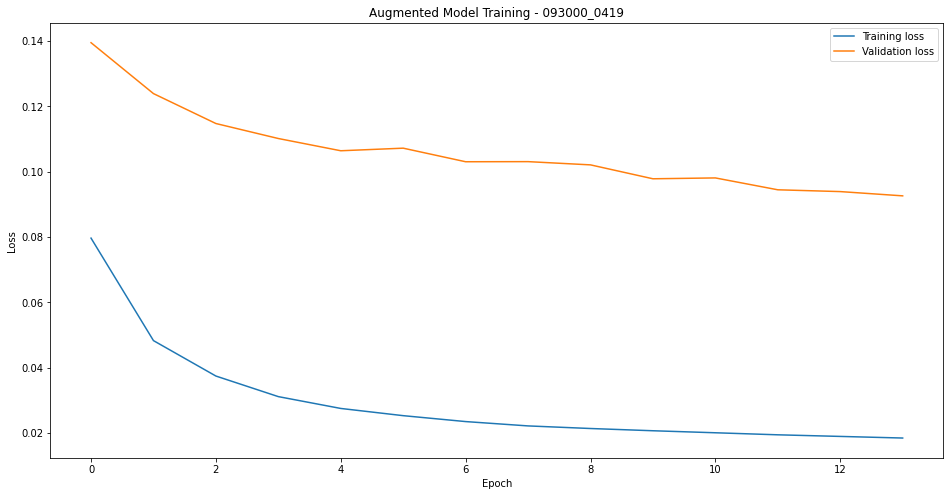

In [78]:
# Fit the model
if os.path.isfile(model_file):
    model = load_model(model_file)
    print(f"Loaded {model_file}")

    model.summary()
    for layer in model.layers:
        print(layer.input_shape)
else:
    # Define AutoEncoder architecture
    model = Sequential()
    # Encoder
    model.add(LSTM(units_one, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(units_two, return_sequences=False))
    # Bridge
    model.add(RepeatVector(trainX.shape[1]))
    #Decoder
    model.add(LSTM(units_two, return_sequences=True))
    model.add(LSTM(units_one, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(TimeDistributed(Dense(trainX.shape[2])))
    model.compile(optimizer='adam', loss='mae')


    model.summary()
    for layer in model.layers:
        print(layer.input_shape)


    callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
    third_history = model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])

    # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(third_history.history['loss'], label='Training loss')
    plt.plot(third_history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Augmented Model Training - {time_code}")
    plt.legend()

    diag_file_name = f'training-{time_code}.png'
    plt.savefig(f'{DIAGRAM_FILE_PATH}{diag_file_name}')

    
    model.save(model_file)
    print(f"Saved as {model_file}")

In [81]:
patientPredict = model.predict(patientX)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

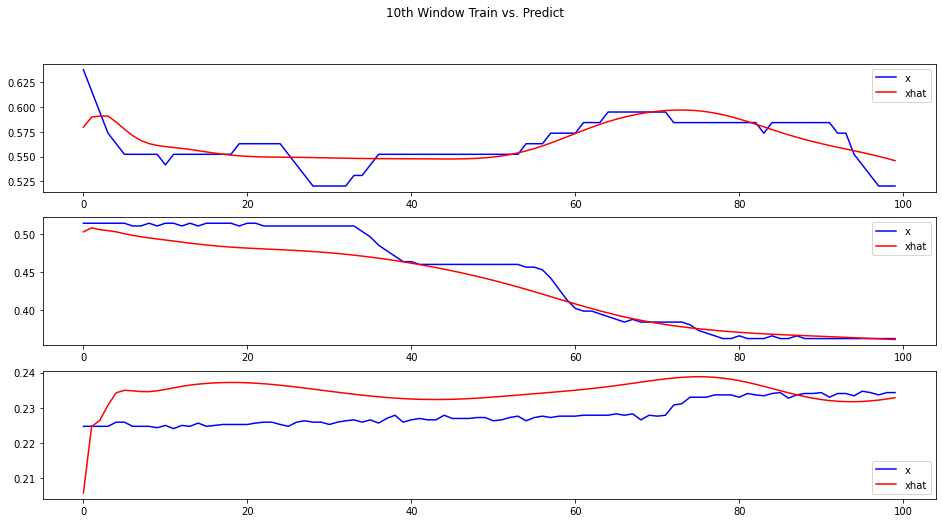

In [82]:
example_plot(10, no_feats, 100, patientX, patientPredict)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

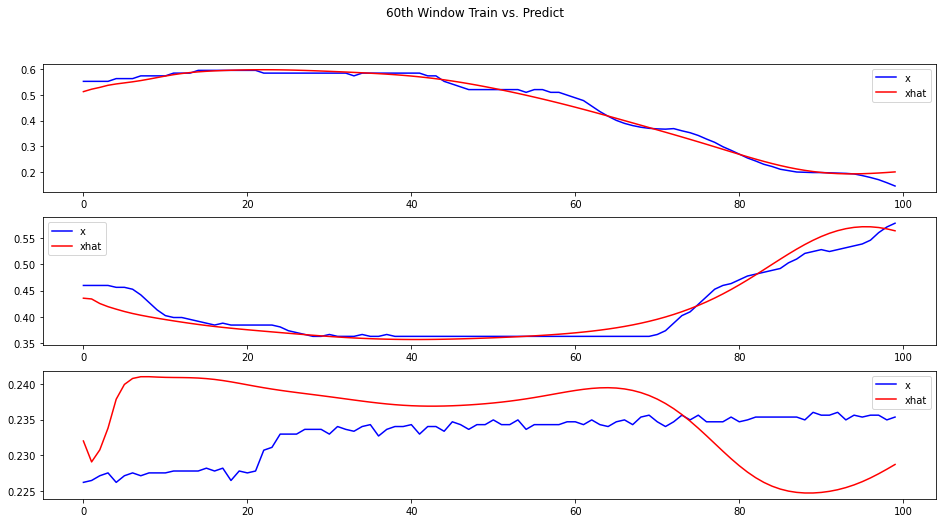

In [85]:
example_plot(60, no_feats, 100, patientX, patientPredict)

In [129]:
MAE = error_computation(patientX, patientPredict)
MAE.shape

(40601, 3)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

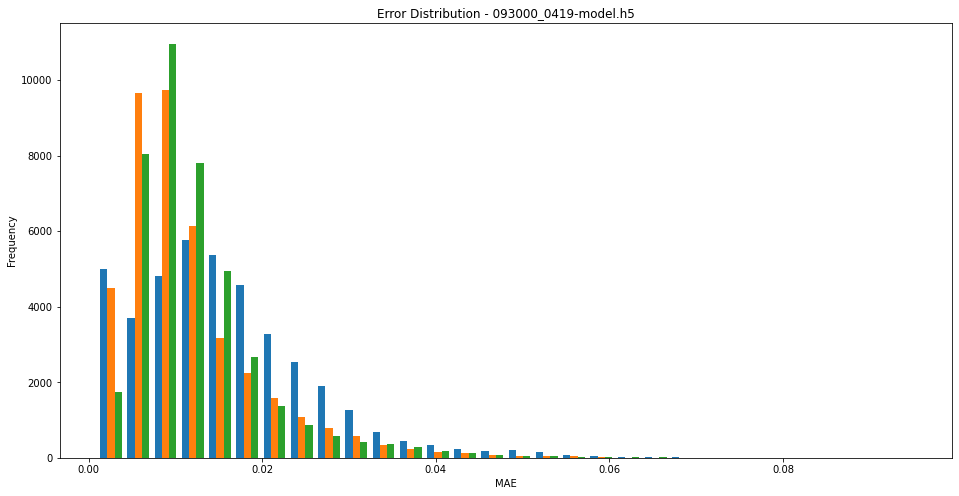

In [130]:
error_hist_and_save(MAE, model_file, DIAGRAM_FILE_PATH)

In [132]:
pct = 0.8
thresh = fixed_thresh(pct, MAE, len(train[seq_size:]))
thresh

array([0.07610999, 0.07610999, 0.07610999, ..., 0.07610999, 0.07610999,
       0.07610999])

In [133]:
anomaly_frame = anomaly_df(train, 100, MAE, thresh)
anomaly_frame.head()

back_angle  left_angle  right_angle                    Date     error  \
100    0.584222    0.362392     0.234301 2011-12-01 11:04:10.000  0.016886   
101    0.584222    0.362392     0.232982 2011-12-01 11:04:10.050  0.015989   
102    0.573561    0.362392     0.234037 2011-12-01 11:04:10.100  0.015911   
103    0.573561    0.362392     0.234037 2011-12-01 11:04:10.150  0.015744   
104    0.552239    0.362392     0.233377 2011-12-01 11:04:10.200  0.015474   

      thresh  anomaly  
100  0.07611    False  
101  0.07611    False  
102  0.07611    False  
103  0.07611    False  
104  0.07611    False

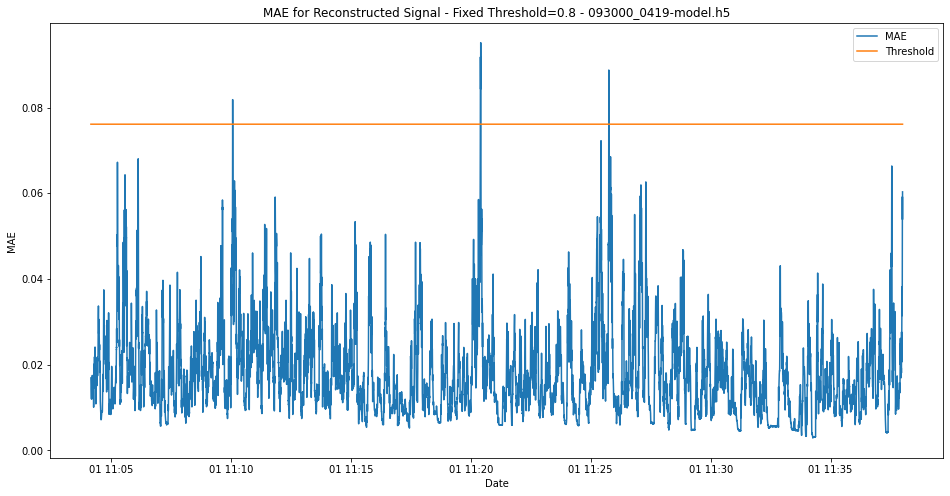

In [136]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, model_file, DIAGRAM_FILE_PATH)

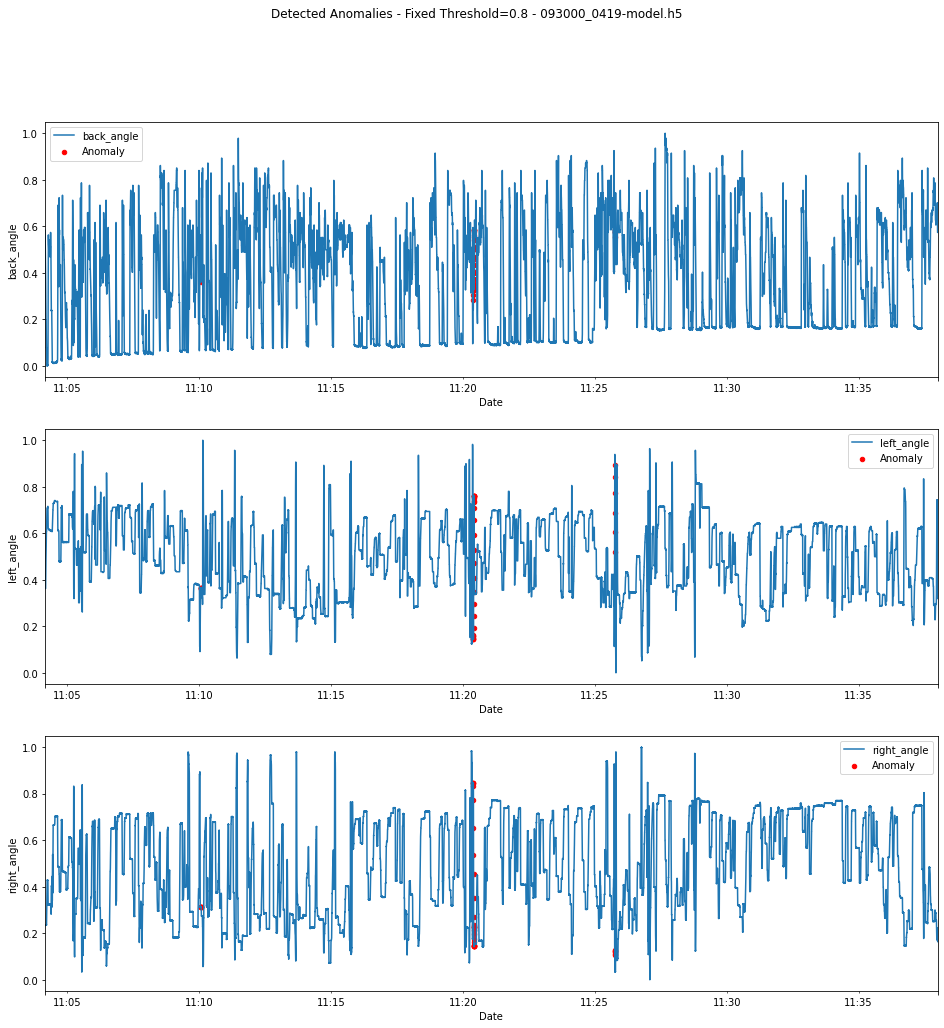

In [137]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_what, anomalies, pct, model_file, DIAGRAM_FILE_PATH)